<h1>K-Means Algorithm - coding and visualization in Python</h1>
<p>In this article we want to take a look at the k-means algorithm. The k-means algorithm is used to determine clusters. It is often the first algorithm you will see in any machine learning introduction, as it is easy to understand. We will code the algorithm in Python and also visualize it.</p>

<h2> Imports </h2>
<p>First of all we need some libraries. We use numpy to ease the array handling and outsource some operations to the way faster C libraries included. By convention we import numpy as np to reduce the length of the code. Next we use pyplot from matplotlib as the name let's one assume, it is used for plotting the data, or here, the pictures as they're nothing else than matrices themselves. By convention matplotlib.pyplot is imported as plt. We also need some methods of the operating system (os) and the Python built-in module math. Last but not least we use imageio to create and save the frames of our animation.</p>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import imageio
import os

%matplotlib inline

N_POINTS = 150 # Number of points
N_CLUSTERS = 5 # Number of clusters
COLORS = ["red", "blue", "green", "brown", "purple"] # Cluster colors

<p>The so called magic function <i>%matplotlib inline</i> allows us to directly see plots without explicitly plotting them. We also define a few static variables respectively <i>N_POINTS</i> for the number of dots we want to display in our k-means algorithm, <i>N_CLUSTERS</i> for the number of clusters we want to use and <i>COLORS</i> for the colors of the clusters.</p>

<h2>Point class representing a 2D point</h2>

In [2]:
class Point:
    
    def __init__(self, x, y, color="grey", magnitude=20):
        # A point has a x and y coordinate, a color and a default magnitude of 20
        self.x = x
        self.y = y
        self.color = color
        self.magnitude = magnitude
        
    def distance_to_point(self, point):
        # Euclidean distance
        delta_x = self.x - point.x
        delta_y = self.y - point.y
        return math.sqrt(delta_x**2+delta_y**2)

<p>Let's start by defining a class to represent a 2-dimensional point that has a simple method to determine it's distance to another point. In this case we use the euclidean distance as it describes the shortest way between two points in the defined space. The euclidean distance is merely the square root of the sum of the squared vector components and the vector between two points can be described as the difference of their x and y values.</p>

<h2> Point list</h2>

In [3]:
class PointList:
    
    def __init__(self, points:[Point]=None, marker="x"):
        if points:
            self.points = points
        else:
            self.points = []
        self.marker = marker
    
    def x_values(self):
        return [point.x for point in self.points]
    
    def y_values(self):
        return [point.y for point in self.points]
    
    def colors(self):
        return [point.color for point in self.points]
    
    def marker(self):
        return [point.marker for point in self.points]
    
    def magnitudes(self):
        return [point.magnitude for point in self.points]
        
    def plot(self):
        return plt.scatter(self.x_values(), self.y_values(), color=self.colors(), marker=self.marker, s=self.magnitudes(), label="Iteration")
    
    def append(self, point):
        self.points.append(point)
        
    def len(self): # implicit override
        return len(self.points)
    
    def x_sum(self):
        return sum([point.x for point in self.points])
    
    def y_sum(self):
        return sum([point.y for point in self.points])
    
    def x_avg(self):
        return self.x_sum()/self.len()
    
    def y_avg(self):
        return self.y_sum()/self.len()
    
    def difference(self, points):
        return sum([own_point.x - list_point.x+ own_point.y - list_point.y for own_point, list_point in zip(self.points, points.points)])

<p>Lets define a list that has some basic features regarding the points. To ease things the list should be able to store and return color, marker type and magnitude, as well as a generalized scatter plot and simple arithmetic operations</p>

<h2>Random points function</h2>

In [4]:
def random_point(**kwargs):
    x = np.random.rand(1) # Create a random value between 0 and 1
    y = np.random.rand(1)
    return Point(x, y, **kwargs) # Return a Point object and proxy the optional keyword args into

<p>As we don't have any actual data, we will randomly generate x and y coordinates that will then be returned as a point instance</p>

In [5]:
def random_points(n):
    points = [random_point() for _ in range(n)] 
    # List comprehension to call the function n times and save the result in a list
    return PointList(points)

<p>To speed things up a bit we use a function that returns a PointList of n points instead of single points</p>

## Create random points and plot them

In [6]:
points = random_points(N_POINTS) # N_Points is defined at the top

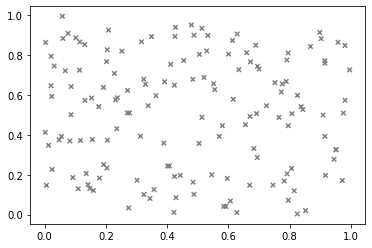

In [7]:
points.plot() # Call the list function to plot the points

<p>Now that we have objects to store the data and functions to create them, we can visualize the created set of points by calling the lists plot function. Due to the magic function at the beginning we don't have to use the pyplot function show, if you use an IDE you might have to add <pre>plt.show()</pre></p>

<h2>Random cluster centres function</h2>

In [8]:
def cluster_centres(k, colors):
    centres = list()
    for color in colors: # Iterate over the colors list
        centres.append(random_point(color=color, magnitude=150)) # Create a random point
    centres = PointList(centres, marker="*") # Save the * marker to the list 
    return centres # Return a PointList of the random centres

<p>Next we define a cluster centre function, that will also generate a random point but with a different color, magnitude and marker. <b>NOTE:</b> The code isn't ideal and I wouldn't use it in a productive project, the marker attribute should belong to the point not the list.</p>

In [9]:
centres = cluster_centres(k=N_CLUSTERS, colors=COLORS) 
# Call the function defined above with the static variables

<h2>Plot points and centres</h2>

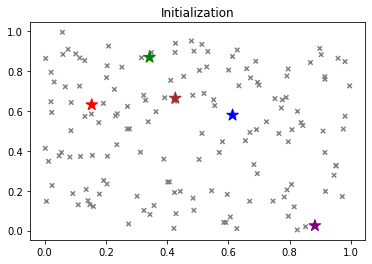

In [10]:
frames = list() # List of frame paths that should be combined to create the gif

points.plot() # Plot the points
centres.plot() # Plot the Cluster centres
plt.title("Initialization") # Title for the first frame
filename =os.path.join(os.getcwd(), "animation", f"frame0.png") # Filename to save the file to
plt.savefig(filename) # Pyplot save function to save the frame as image

frames.append(filename) # Append the filename to the frames list

## Cluster points function

In [11]:
def cluster_points(points, centres):
    points =  points.points # Reduces the complexity of the code
    centres = centres.points
    clusters = list([PointList() for _ in range(len(centres))]) # Create as many lists as there are centres, as
    # each point will belong to a single cluster
    for point in points: # Iterate over the points
        distances = [point.distance_to_point(centre) for centre in centres] 
        # List comprehension to determine the distance from a point to each centre
        min_distance = min(distances) # Get the value of the shortest distance
        centre_index = distances.index(min_distance) # Get the index that belongs to that value
        centre = centres[centre_index] # The centre that is closest to the point is described by the index value
        clusters[centre_index].append(point) # Append the point to the list that belongs to that clusters
        point.color = centre.color # Recolor the point in the color of the cluster centre for visualization
    return clusters # Returns as many lists as there are cluster centres, each cluster represents all points
    # closest to the specific cluster centre

<p>As described in the code above, we need to cluster the points based on their distance to the closest centre.</p>

## Calculate mid of clusters

In [12]:
def calculate_new_centres(clusters):
    new_centres = PointList(marker="*") # Create a PointList of centres
    for cluster in clusters: # Iterate over centres
        x_avg = cluster.x_avg() # Get average x value of all points in the cluster
        y_avg = cluster.y_avg() # Get average y value of all points in the cluster
        new_centres.append(Point(x=x_avg, y=y_avg, color=cluster.colors()[0], magnitude=150)) 
        # Add the new centres to the PointList 
    return new_centres # Returns as many centres as initially provided

<p>After assigning each point to a cluster we have to recalculate the position of the centre. The centre should be exactly in the centre of all points that belong to the cluster.</p>

<h2>Testing</h2>

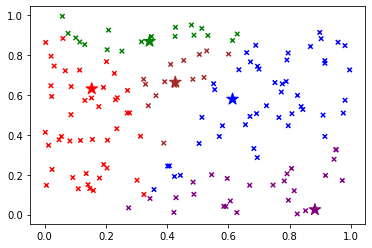

In [13]:
clusters = cluster_points(points, centres)
points.plot()
centres.plot()

<p>If everything went as desired, we now get the picture of the k-means algorithm before the centres get rebalanced for the first time, but with the points already clustered in place</p>

<h2>The k-means algorithm steps</h2>

In [14]:
epsilon = 0.1E-19 # Allowed difference to be cointed as zero, to avoid numerical issues based on binary numbers
difference = 1 # Initial difference of the clusters between an iteration
n = 1 # Step variable, is 1 as we already generated the initial frame

while abs(difference) >= 0 + epsilon: 
    # If the difference between the current cluster position and the position in the iteration before is 
    # (close to) zero, the algorithm has finished
    new_clusters = cluster_points(points, centres) # Calculate the new clusters based on the current centres
    new_centres = calculate_new_centres(new_clusters) # Calculate the new centres based on the clusters
    difference = new_centres.difference(centres) 
    # Evaluate the difference between the centre positions before and after
    
    # Animation
    points.plot() # Plot points with the PlotList.plot() function
    centres.plot()
    plt.title(f'Iteration {n}') # Set the Plot title, based on the current iteration
    filename =os.path.join(os.getcwd(), "animation", f"frame{n}.png") 
    # Create a filename the frame should be saved to
    plt.savefig(filename) # Save image
    frames.append(filename) # Append filename to frames
    plt.close() # Ensure we clear the main memory reserved to that plot
    # /Animation
    
    centres = new_centres # Exchange the old centres by the new ones
    n+=1 # Increase the step counter

<p><b>NOTE:</b> This isn't the full algorithm, this is merely the part that happend after the intiailization</p>

<h2>Create Animation from frames</h2>

In [15]:
with imageio.get_writer('animation/animation.gif', mode='I', duration=0.7) as writer: 
    # Open an imageio writer with a given filename and the stream mode (I), set the duration for each frame to
    # 0.7 seconds
    for frame in frames: # Iterate over the filenames
        image = imageio.imread(frame) # Load the image
        writer.append_data(image) # Write the image to the stream

<img src="https://github.com/code-specialist/code-specialist/blob/master/jupyter%20notebooks/k-means-algorithm/animation/animation.gif"/>

<p><b>NOTE:</b> The gif has been loaded as HTML: <code>&lt;img src="animation/animation.gif"/&gt;</code></p>

<h2>Closing</h2>
<p>I hope you enjoyed this kind of blog post format and we're able to reproduce the animation as expected. If you run into any issues or need further help, don't hesitate to contact us via the comment or contact form!</p>